Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, Rescaling
from keras import Sequential

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/CNN/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

scancer_names=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    #labels='inferred',
    #label_mode='int',
    #class_names=scancer_names,
    #color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    #shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    #interpolation='bilinear',
    #follow_links=False,
    #crop_to_aspect_ratio=False,
    #pad_to_aspect_ratio=False,
    #data_format=None,
    #verbose=True
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    #labels='inferred',
    #label_mode='int',
    #class_names=scancer_names,
    #color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    #shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    #interpolation='bilinear',
    #follow_links=False,
    #crop_to_aspect_ratio=False,
    #pad_to_aspect_ratio=False,
    #data_format=None,
    #verbose=True
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    #labels='inferred',
    #label_mode='int',
    #class_names=scancer_names,
    #color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    #shuffle=True,
    seed=123,
    #validation_split=0.2,
    #subset="validation",
    #interpolation='bilinear',
    #follow_links=False,
    #crop_to_aspect_ratio=False,
    #pad_to_aspect_ratio=False,
    #data_format=None,
    #verbose=True
)

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

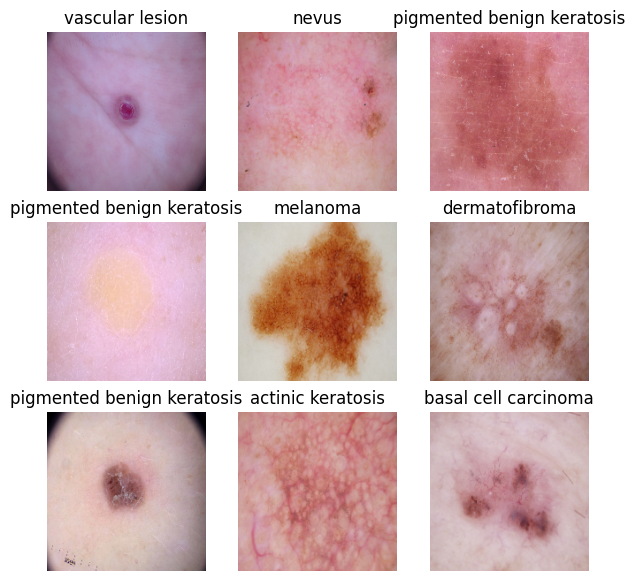

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
# Number of classes in dataset
num_classes = 9
input_shape = (img_height, img_width, 3)

model = Sequential()

# Adding rescaling Layer

#Use one_hot encoding when using CategoricalCrossEntropy
#train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))  # Replace num_classes
#val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))  # Replace num_classes
model.add(keras.layers.Rescaling(1./255,input_shape=(180,180,3)))

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 padding='same',
                 input_shape=input_shape)) # input shape = (img_height, img_width, 3)
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(64, activation='relu')) # fully connected

# softmax layer
model.add(keras.layers.Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      16,588,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,590,473 (63.29 MB)

 Trainable params: 16,590,409 (63.29 MB)

 Non-trainable params: 64 (256.00 B)

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 489ms/step - accuracy: 0.2723 - loss: 3.4341 - val_accuracy: 0.1723 - val_loss: 2.2733
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3967 - loss: 1.6957 - val_accuracy: 0.3602 - val_loss: 1.9124
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4740 - loss: 1.4975 - val_accuracy: 0.4295 - val_loss: 1.8596
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5359 - loss: 1.3001 - val_accuracy: 0.3311 - val_loss: 1.7590
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5715 - loss: 1.2109 - val_accuracy: 0.1969 - val_loss: 4.0385
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6063 - loss: 1.0655 - val_accuracy: 0.4877 - val_loss: 1.5894
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6531 - loss: 0.9614 - val_accuracy: 0.4966 - val_loss: 1.5022
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6911 - loss: 0.8468 - val_accuracy: 0.4698 

### Visualizing training results

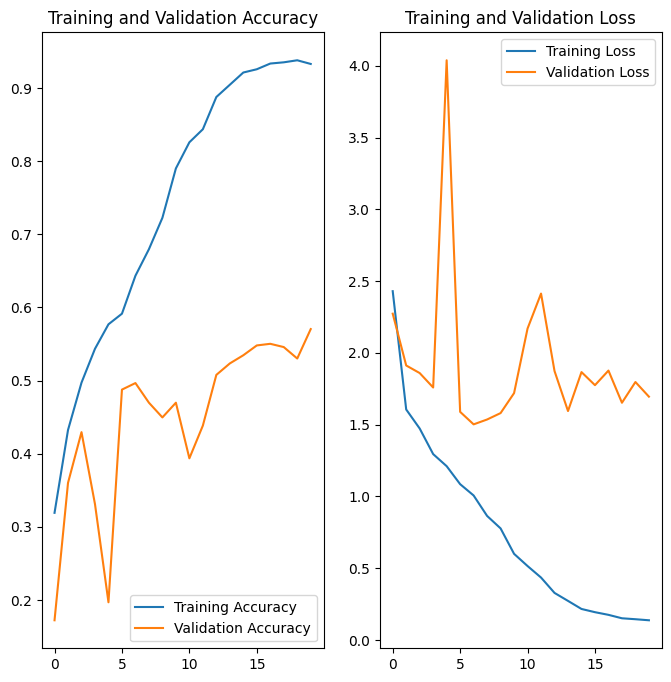

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

1. The model seem to overfit given the high train accurarcy and low validation accuracy.
2. The training losses seems to consistently decrease with each epoc however the same is not true with validation losses.
3. It would be interesting to see trying some additional data augmentation techniques like RandomFlip, RandomRotation etc. with the same model. Hoping to get a stable model with less gap in train and validation dataset.

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Along with rescaling as used earlier, this time going to use random flip as well as random rotation to check if this improves the accuracy
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
#val_ds = val_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

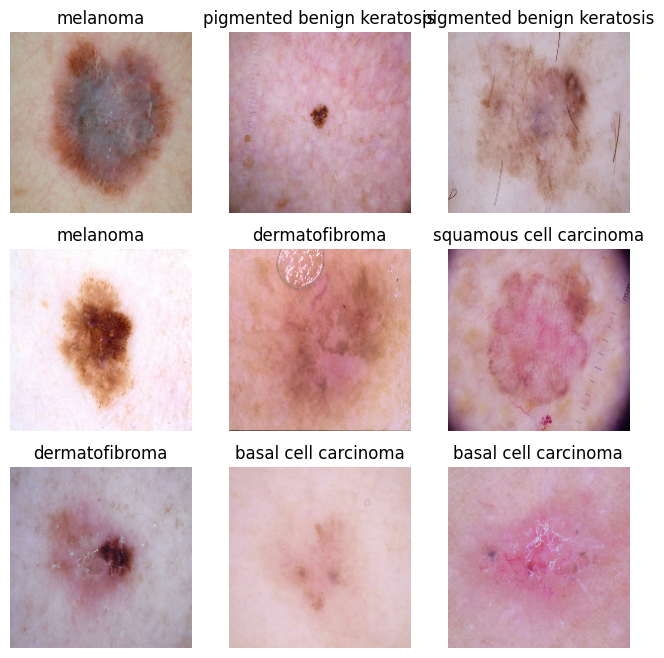

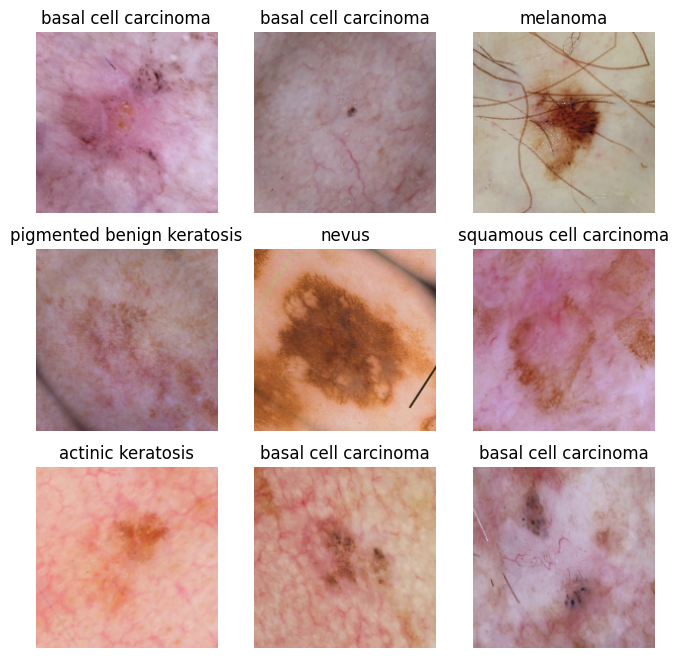

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

#Before data augmentation
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

train_ds = train_ds.take(1).map(lambda x, y: (data_augmentation(x, training=True), y))

#After data augmentation
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# Number of classes in dataset
num_classes = 9
input_shape = (img_height, img_width, 3)

model = Sequential()

# Adding rescaling Layer
model.add(keras.layers.Rescaling(1./255,input_shape=(180,180,3)))

# Adding data augmentation layer
model.add(data_augmentation)

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 padding='same',
                 input_shape=input_shape)) # input shape = (img_height, img_width, 3)
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(64, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(keras.layers.Dense(num_classes, activation='softmax'))



### Compiling the model

In [21]:
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 32
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=batch_size
)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1562 - loss: 2.4042 - val_accuracy: 0.1499 - val_loss: 9.1749
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.2188 - loss: 19.3278 - val_accuracy: 0.0761 - val_loss: 3.6459
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.1875 - loss: 5.5488 - val_accuracy: 0.1924 - val_loss: 5.0210
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.0625 - loss: 7.7976 - val_accuracy: 0.1499 - val_loss: 2.9272
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.2500 - loss: 3.9817 - val_accuracy: 0.1275 - val_loss: 2.2348
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.0938 - loss: 2.8964 - val_accuracy: 0.2707 - val_loss: 2.0867
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.1875 - loss: 2.2966 - val_accuracy: 0.2707 - val_loss: 2.1472
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.3438 - loss: 1.9943 - val_accuracy: 0.2528 - val_loss: 2

### Visualizing the results

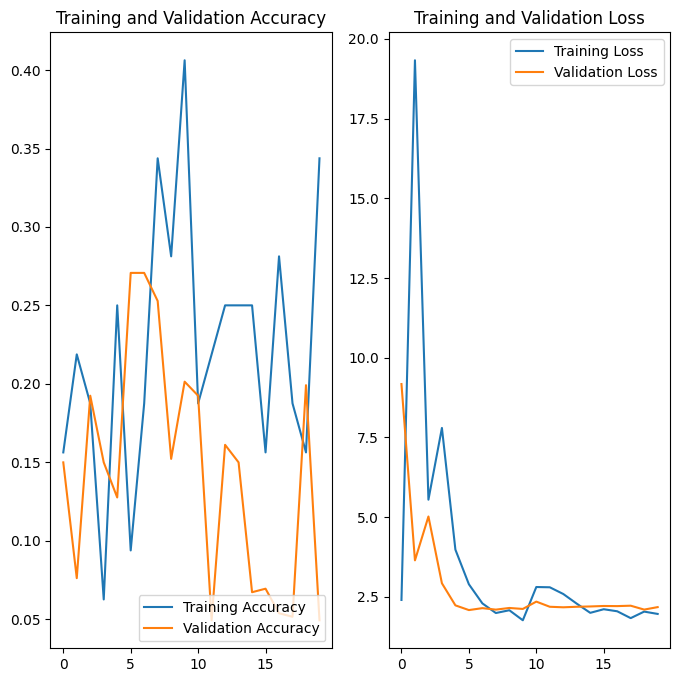

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

1. These runs does not look promising as the accuracy have gone down for both train and validation dataset though the model now seems more stable as compared to before scaling.
2. The inconsistencies (spikes) in validation learning accuracy as well as losses may be indicative of the dataset imbalance(more data for specific kind of skin cancers and less for others)
3. The model may become more stable with additional feature extraction with subsequent layers and  more generalised learning with progress layers.
4. Data balancing and additional augmentations should help in reducing the overfitting problem.
5. The next model might need to be run for more epochs as evident from the last run that increasing the variety\variation may lead to slow learning.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Axes: xlabel='Class', ylabel='No. of Image'>

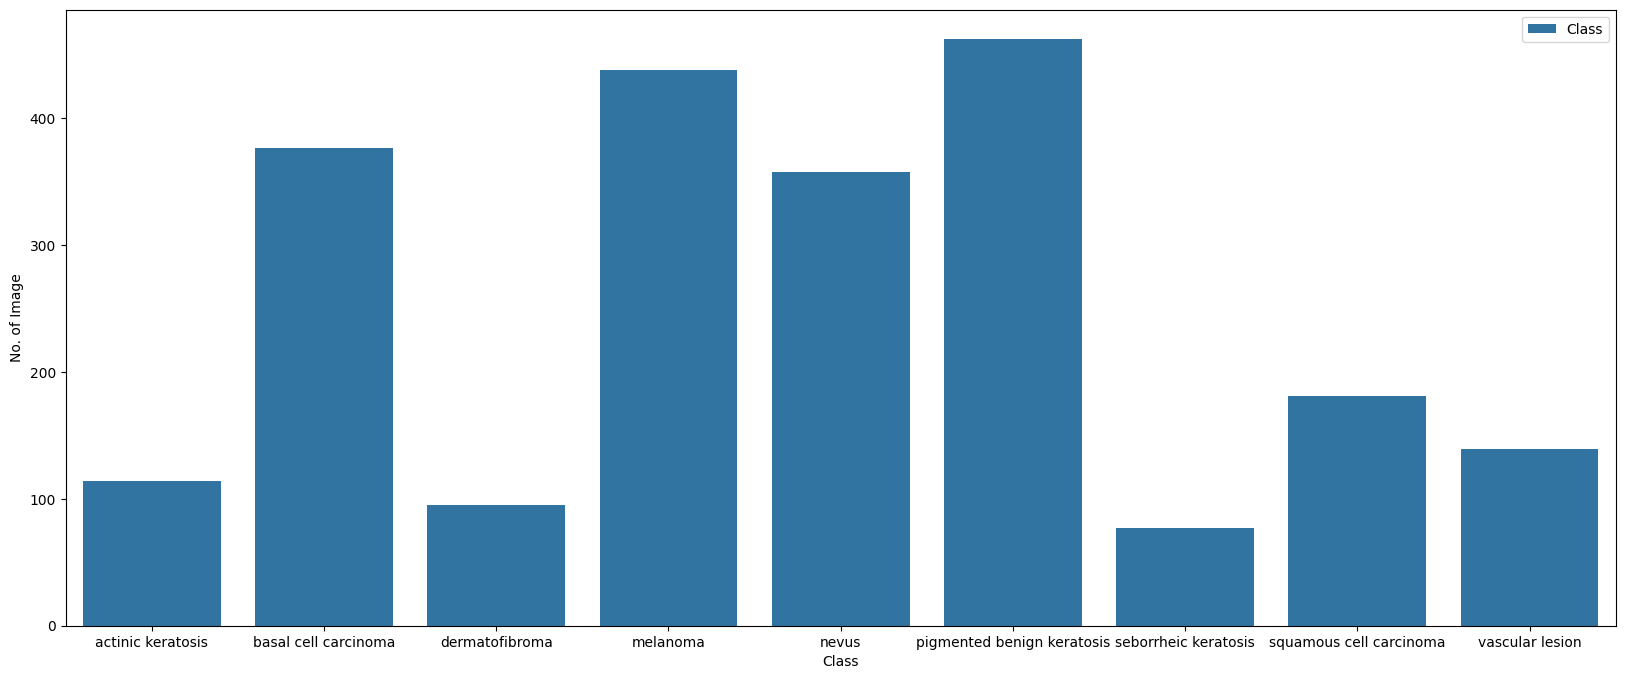

In [24]:
## Find distribution of classes
def class_distribution_count(directory):

    # Image count in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    # Class Names
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    # return df with class name and correspnding number of images
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)

#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(20, 8))
sns.barplot(x="Class", y="No. of Image", data=df,
            label="Class")

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
seborrheic keratosis, dermatofibroma and actinic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
melanoma, pigmented bening keratosis, basal cell carcinoma and nevus


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:

import Augmentor

path_to_training_dataset = data_dir_train

for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset / i))  # Use the / operator for path concatenation
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AFC901C3460>: 100%|██████████| 500/500 [00:05<00:00, 89.73 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AFC8072B250>: 100%|██████████| 500/500 [00:05<00:00, 96.47 Samples/s] 


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AFD3C39B640>: 100%|██████████| 500/500 [00:04<00:00, 104.17 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7AFC80776A70>: 100%|██████████| 500/500 [00:13<00:00, 36.59 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7AFC80776E60>: 100%|██████████| 500/500 [00:12<00:00, 40.80 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AFC90294E20>: 100%|██████████| 500/500 [00:04<00:00, 109.24 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7AFC8071ABF0>: 100%|██████████| 500/500 [00:07<00:00, 70.72 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AFC901C2020>: 100%|██████████| 500/500 [00:04<00:00, 109.17 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AFC901ABB50>: 100%|██████████| 500/500 [00:04<00:00, 111.90 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
import os
from glob import glob # Import the glob function

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/CNN/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032854.jpg_bf27f976-d2c8-4f44-9842-1b8a2f7a35db.jpg',
 '/content/drive/MyDrive/CNN/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033456.jpg_50e35810-89aa-4778-b56a-a7f61777b0c5.jpg',
 '/content/drive/MyDrive/CNN/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027452.jpg_8d2fbeee-2d46-4842-a404-6aca4bac43f1.jpg',
 '/content/drive/MyDrive/CNN/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029460.jpg_85133b21-fa05-48a6-b862-1ea46e9eeca4.jpg',
 '/content/drive/MyDrive/CNN/Melanoma_Detect

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
import pandas as pd
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = pd.DataFrame(columns=['Path', 'Label']) # Create an empty DataFrame with the same columns as df2
#new_df = original_df.append(df2)
new_df = pd.concat([original_df, df2], ignore_index=True) # Use pd.concat to combine the dataframes.

In [32]:
new_df['Label'].value_counts()

,count
Label,
actinic keratosis,500
basal cell carcinoma,500
dermatofibroma,500
melanoma,500
nevus,500
pigmented benign keratosis,500
seborrheic keratosis,500
squamous cell carcinoma,500
vascular lesion,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [34]:
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [36]:
num_classes = 9
input_shape = (img_height, img_width, 3)

model = Sequential()

# Adding rescaling Layer
model.add(keras.layers.Rescaling(1./255,input_shape=(180,180,3)))

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 padding='same',
                 input_shape=input_shape)) # input shape = (img_height, img_width, 3)
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

# Second conv layer
model.add(Conv2D(64, kernel_size=(3, 3),
                 padding='same',
                 input_shape=input_shape)) # input shape = (img_height, img_width, 3)
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.30))

# Third conv layer
model.add(Conv2D(128, kernel_size=(3, 3),
                 padding='same',
                 input_shape=input_shape)) # input shape = (img_height, img_width, 3)
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(256, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(keras.layers.Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [37]:
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [38]:
epochs = 50

## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.2571 - loss: 4.5798 - val_accuracy: 0.1151 - val_loss: 12.3868
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.3867 - loss: 1.6213 - val_accuracy: 0.1559 - val_loss: 9.2694
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.4377 - loss: 1.5279 - val_accuracy: 0.3326 - val_loss: 4.5633
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.4699 - loss: 1.3881 - val_accuracy: 0.4692 - val_loss: 2.4150
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.5102 - loss: 1.3088 - val_accuracy: 0.5189 - val_loss: 1.9448
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.5432 - loss: 1.2200 - val_accuracy: 0.3274 - val_loss: 6.5768
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.5511 - loss: 1.1936 - val_accuracy: 0.4098 - val_loss: 2.5584
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.5680 - loss: 1.1003 

#### **Todo:**  Visualize the model results

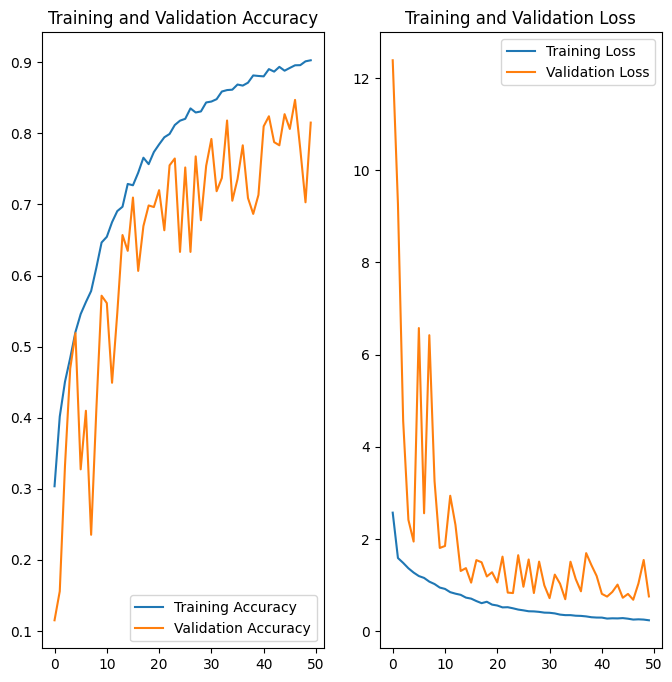

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
1. The class rebalance has definitely helped as we can clearly see from the above chart the consistent decrease in validation losses.
2. The overfitting has also significantly reduced and gap between training and validation accuracies has come down significantly.
3. We can ignore the gap in the last epoch and focus on the above graph which shows consitency between parameters of train and validation dataset.
